In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pjoshi15_stock_images_path = kagglehub.dataset_download('pjoshi15/stock-images')

print('Data source import complete.')


100%|██████████| 56.4k/56.4k [00:00<00:00, 1.11MB/s]

Extracting files...
Data source import complete.


In this notebook, I will use Stable Diffusion inpainting and Segment Anything Model to [change clothes in a photo](https://pjoshi15.com/change-clothes-stable-diffusion-sam/).

I will be using a stock image for this experiment. You will be able to access that image once you run this notebook.

Let's get started!

In [ ]:
!pip install diffusers

In [ ]:
import torch
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt

## Load input image

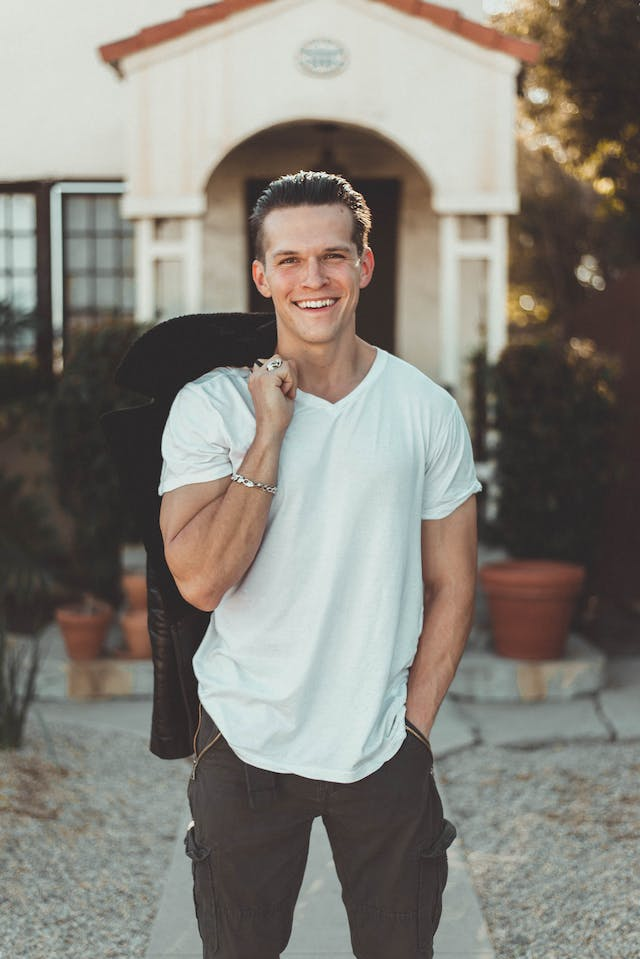

In [ ]:
# load image
img = load_image("/content/white_tshirt.jpg")

# display image
img

## Import SlimSAM for creating masks

Now I will import the [SLimSAM model](https://github.com/czg1225/SlimSAM). This model will be used to segment the object of our choice.

In [ ]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to("cuda")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/365 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

## Create mask for T-shirt

In [ ]:
input_points = [[[320, 600]]] # coordinates of a point on the object of interest

inputs = processor(img, input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)

# extract mask tensors
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [ ]:
# count number of masks
len(masks[0][0])

3

Now you can plot all these masks one-by-one and see which one is the best for the object that you want to select.

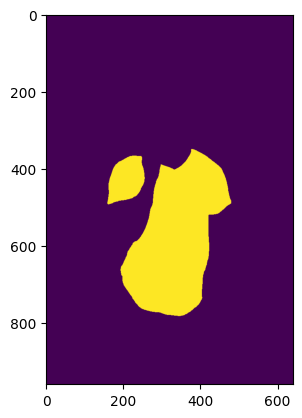

In [ ]:
# best mask tensor
plt.imshow(masks[0][0][2])

## Create mask for pants

In [ ]:
input_points_2 = [[[200, 850]]] # coordinates of a point on the object of interest

inputs_2 = processor(img, input_points=input_points_2, return_tensors="pt").to("cuda")
outputs_2 = model(**inputs_2)
masks_2 = processor.image_processor.post_process_masks(outputs_2.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [ ]:
# count number of masks
len(masks_2[0][0])

3

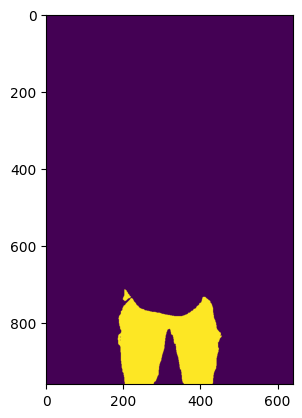

In [ ]:
plt.imshow(masks_2[0][0][1])

## Convert PyTorch tensors to PIL image format

In [ ]:
# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# Convert boolean tensors to binary tensors
binary_matrix_1 = masks[0][0][2].to(dtype=torch.uint8)
binary_matrix_2 = masks_2[0][0][1].to(dtype=torch.uint8)

# apply the transform to the tensors (tensor to PIL)
mask_1 = to_pil(binary_matrix_1*255)
mask_2 = to_pil(binary_matrix_2*255)

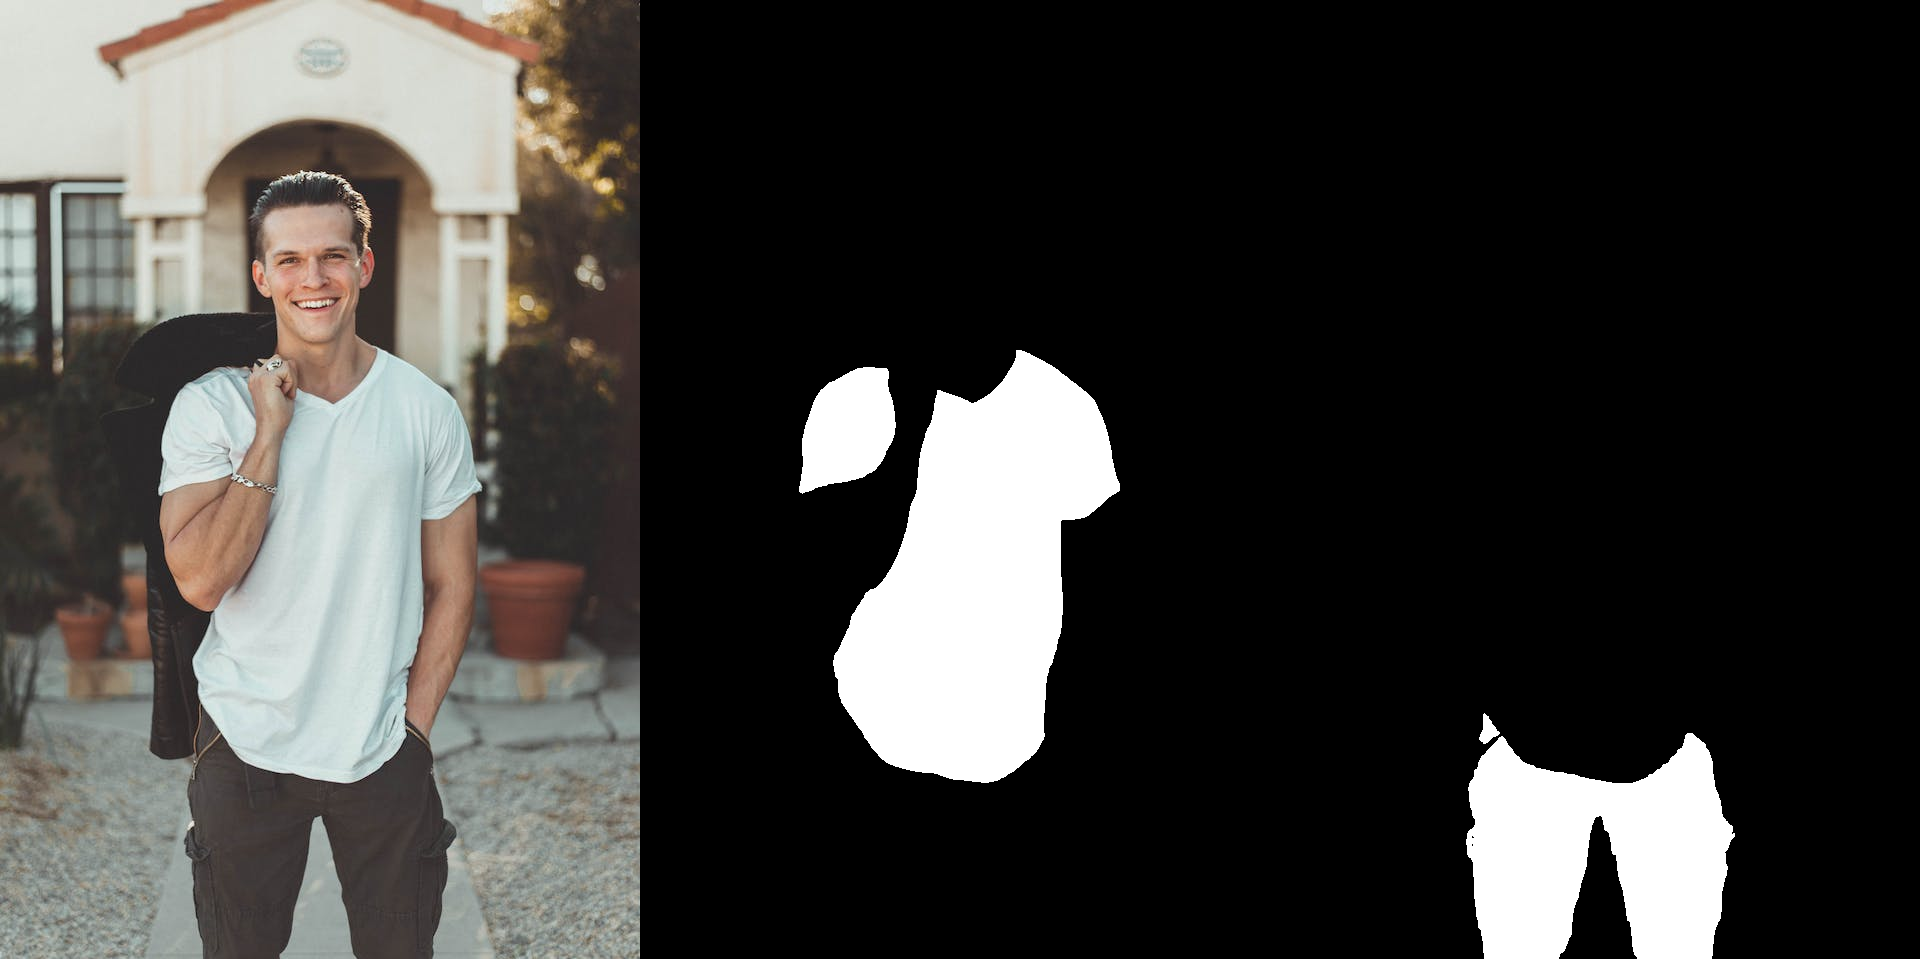

In [ ]:
# display original image with masks
make_image_grid([img, mask_1, mask_2], cols = 3, rows = 1)

## Import Stable Diffusion inpainting model

In [ ]:
# Create inpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Edit T-shirt in image

In [ ]:
prompt = "flower-print, t-shirt"

# inpainting pipeline
image1 = pipeline(prompt=prompt,
                 width=512,
                 height=768,
                 num_inference_steps=28,
                 image=img,
                 mask_image=mask_1,
                 guidance_scale=3,
                 strength=1.0).images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

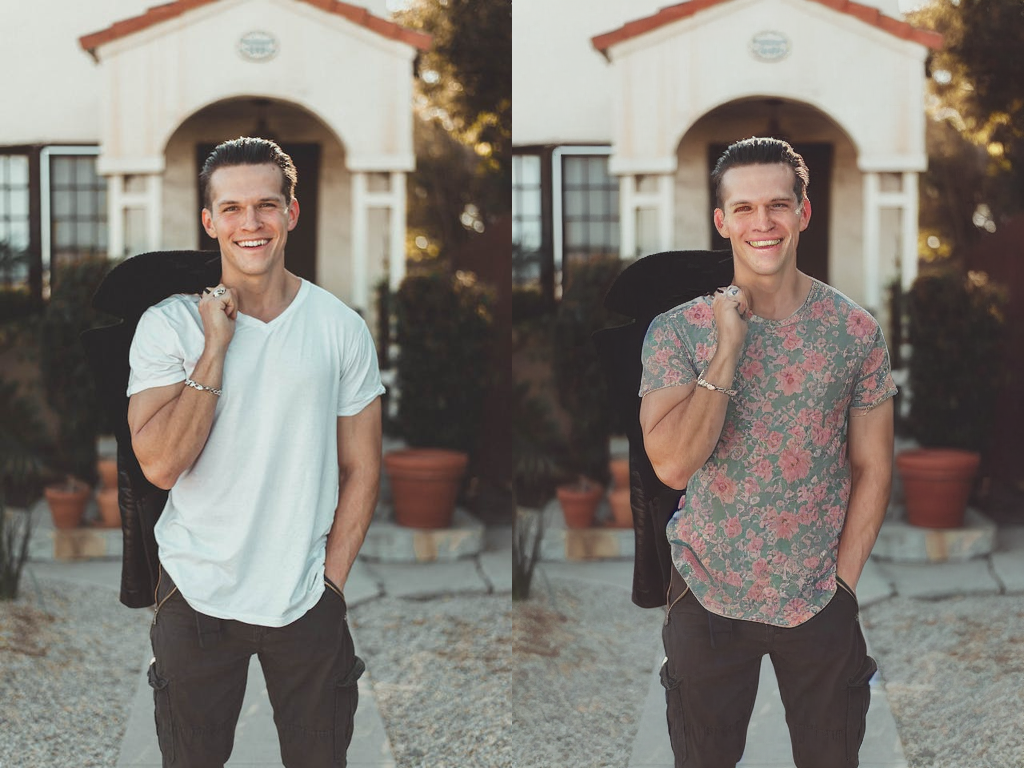

In [ ]:
# compare input and output
make_image_grid([img.resize([512,768]), image1], rows = 1, cols = 2)

## Edit pants in image

  0%|          | 0/30 [00:00<?, ?it/s]

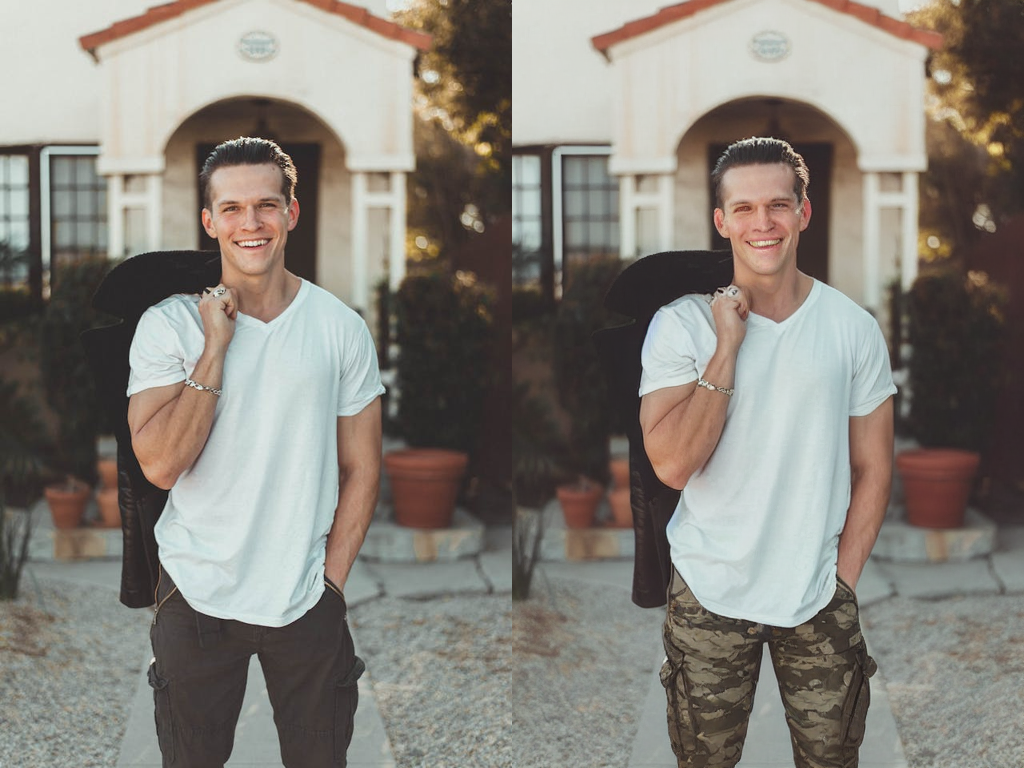

In [ ]:
prompt = "tactical pants"

image = pipeline(prompt=prompt,
                 width=512,
                 height=768,
                 num_inference_steps=30,
                 image=img,
                 mask_image=mask_2,
                 guidance_scale=2.5,
                 strength=1.0).images[0]

make_image_grid([img.resize([512,768]), image], rows = 1, cols = 2)

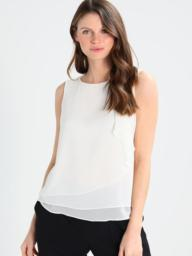

In [ ]:
# load image
img = load_image("/content/019490_0.jpg")

# display image
img

In [ ]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to("cuda")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
input_points = [[[100, 150]]] # coordinates of a point on the object of interest

inputs = processor(img, input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)

# extract mask tensors
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [ ]:
# count number of masks
len(masks[0][0])

3

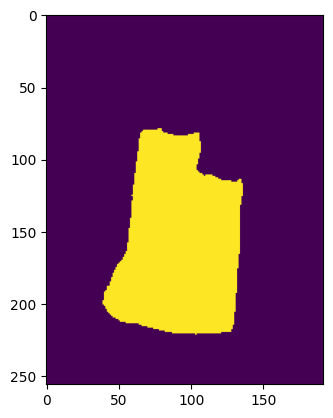

In [ ]:
# best mask tensor
plt.imshow(masks[0][0][2])

In [ ]:
input_points_2 = [[[100, 210]]] # coordinates of a point on the object of interest

inputs_2 = processor(img, input_points=input_points_2, return_tensors="pt").to("cuda")
outputs_2 = model(**inputs_2)
masks_2 = processor.image_processor.post_process_masks(outputs_2.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

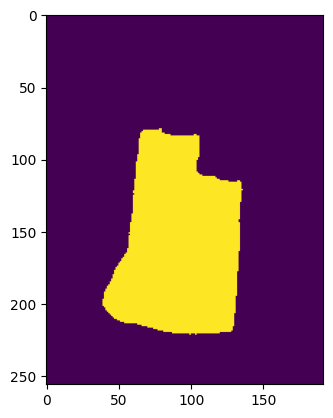

In [ ]:
plt.imshow(masks_2[0][0][1])

In [ ]:
# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# Convert boolean tensors to binary tensors
binary_matrix_1 = masks[0][0][2].to(dtype=torch.uint8)


# apply the transform to the tensors (tensor to PIL)
mask_1 = to_pil(binary_matrix_1*255)


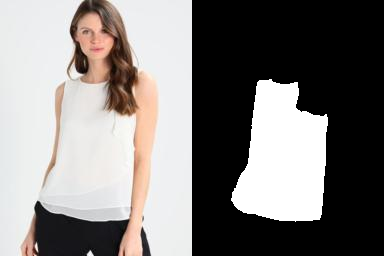

In [ ]:
make_image_grid([img, mask_1], cols = 2, rows = 1)

In [ ]:
# Create inpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/p

In [ ]:
img.size

(192, 256)

In [ ]:
prompt = "flower-print, t-shirt"

# inpainting pipeline
image1 = pipeline(prompt=prompt,
                 width=192,
                 height=256,
                 num_inference_steps=28,
                 image=img,
                 mask_image=mask_1,
                 guidance_scale=3,
                 strength=1.0).images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

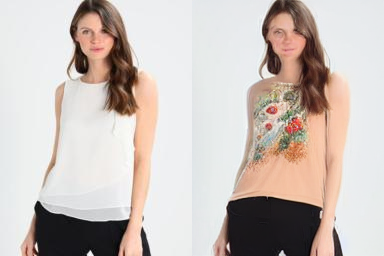

In [ ]:
# compare input and output
make_image_grid([img.resize([192,256]), image1], rows = 1, cols = 2)

We can also use an [IP-Adapter model](https://pjoshi15.com/generate-images-ipadapters-diffusers/) here to use an existing dress and guide the model to generate a similar dress. There is a wide range of things that we can do if we combine different AI models, like how combining SlimSAM and Stable Diffusion helped in generating new clothes in the images.